# **Dataset 4**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval



### **Exploratory Data Analysis**

In [2]:
# Load dataset as dataframe
data_path = "Original_Data/Dataset_4.csv"
original_data = pd.read_csv(data_path)
original_data.head()


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [4]:
# Check for missing values
original_data.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Found 173 missing values in column 'score'. Replace with mean value.

In [5]:
original_data.fillna(original_data.mean().round(0), inplace=True)
original_data.isnull().sum()

id_assessment     0
id_student        0
date_submitted    0
is_banked         0
score             0
dtype: int64

In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173912 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


<Axes: xlabel='score', ylabel='Count'>

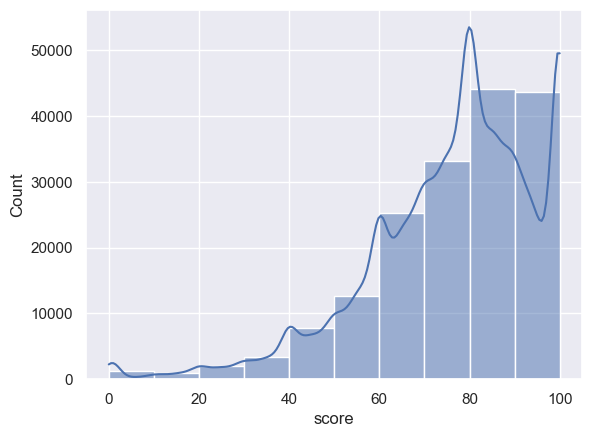

In [12]:
# Check score distribution
sns.histplot(original_data['score'], bins=10, kde=True)

In [14]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

### **Synthetic Data Generation**

In [13]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/train_data.csv", index=False)
test_data.to_csv("Original_Data/test_data.csv", index=False)

In [50]:
# Use train_data.csv to fit SDG models and generate synthetic data
data_path = "Original_Data/train_data.csv"
arguments = [data_path, str(n)]

print("Sampling synthpop...")
result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

print("Sampling DataSynthesizer...")
ds_generate_data(data_path=data_path, num_samples=n)

sdv_generate_data(data_path=data_path, num_samples=n)

Sampling synthpop...


Sampling DataSynthesizer...
================ Constructing Bayesian Network (BN) ================
Adding ROOT Discussion
Adding attribute Relation
Adding attribute AnnouncementsView
Adding attribute raisedhands
Adding attribute Semester
Adding attribute SectionID
Adding attribute VisITedResources
Adding attribute GradeID
Adding attribute StudentAbsenceDays
Adding attribute Class
Adding attribute PlaceofBirth
Adding attribute ParentAnsweringSurvey
Adding attribute StageID
Adding attribute Topic
Adding attribute ParentschoolSatisfaction
Adding attribute gender
Adding attribute NationalITy
========================== BN constructed ==========================
Fitting copula_gan...

Time taken to fit copula_gan: 7.75 seconds

Fitting ctgan...

Time taken to fit ctgan: 8.13 seconds

Fitting tvae...

Time taken to fit tvae: 1.90 seconds

Fitting gaussian_copula...

Time taken to fit gaussian_copula: 0.36 seconds



Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [51]:
from sklearn.preprocessing import LabelEncoder

synthpop = pd.read_csv("Synthetic_Data/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le


### **Utility Evaluation**

Prepare utility evaluation

In [ ]:
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "score"

Run random forest classifier for utility evaluation

In [52]:
rf_results = {}
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")
    print(rf_results[model_names[i]])

Model:  synthpop
{'acc_original': 0.8125, 'f1_original': 0.8122423783819387, 'acc_synth': 0.7569444444444444, 'f1_synth': 0.7542251322531889, 'acc_diff': 0.05555555555555558, 'f1_diff': 0.05801724612874981}
Model:  ds
{'acc_original': 0.8125, 'f1_original': 0.8122423783819387, 'acc_synth': 0.3472222222222222, 'f1_synth': 0.33788761671096573, 'acc_diff': 0.4652777777777778, 'f1_diff': 0.47435476167097296}
Model:  tvae
{'acc_original': 0.8125, 'f1_original': 0.8122423783819387, 'acc_synth': 0.5416666666666666, 'f1_synth': 0.4481424079065588, 'acc_diff': 0.27083333333333337, 'f1_diff': 0.3640999704753799}
Model:  gaussian_copula
{'acc_original': 0.8125, 'f1_original': 0.8122423783819387, 'acc_synth': 0.4444444444444444, 'f1_synth': 0.3852839663024848, 'acc_diff': 0.3680555555555556, 'f1_diff': 0.4269584120794539}
Model:  copula_gan
{'acc_original': 0.8125, 'f1_original': 0.8122423783819387, 'acc_synth': 0.3541666666666667, 'f1_synth': 0.3139690170940171, 'acc_diff': 0.4583333333333333, 'f

Run logistic regression for utility evaluation

In [53]:
lr_results = {}
for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

for name in model_names:
    print(name)
    print(lr_results[name], "\n")

synthpop
{'acc_original': 0.7777777777777778, 'f1_original': 0.775057139888837, 'acc_synth': 0.7569444444444444, 'f1_synth': 0.7520205083496556, 'acc_diff': 0.02083333333333337, 'f1_diff': 0.02303663153918134} 

ds
{'acc_original': 0.7777777777777778, 'f1_original': 0.775057139888837, 'acc_synth': 0.4236111111111111, 'f1_synth': 0.37459927443685564, 'acc_diff': 0.3541666666666667, 'f1_diff': 0.4004578654519813} 

tvae
{'acc_original': 0.7777777777777778, 'f1_original': 0.775057139888837, 'acc_synth': 0.5833333333333334, 'f1_synth': 0.5183369135456555, 'acc_diff': 0.19444444444444442, 'f1_diff': 0.2567202263431815} 

gaussian_copula
{'acc_original': 0.7777777777777778, 'f1_original': 0.775057139888837, 'acc_synth': 0.4236111111111111, 'f1_synth': 0.34467389538661464, 'acc_diff': 0.3541666666666667, 'f1_diff': 0.4303832445022223} 

copula_gan
{'acc_original': 0.7777777777777778, 'f1_original': 0.775057139888837, 'acc_synth': 0.4583333333333333, 'f1_synth': 0.3074404761904762, 'acc_diff':

Run multilayer perceptron (MLP)

In [54]:
mlp_results = {}
for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

for name in model_names:
    print(name)
    print(mlp_results[name], "\n")

synthpop
{'acc_original': 0.6944444444444444, 'f1_original': 0.6972228886348013, 'acc_synth': 0.7013888888888888, 'f1_synth': 0.693943676055745, 'acc_diff': -0.00694444444444442, 'f1_diff': 0.0032792125790562787} 

ds
{'acc_original': 0.6944444444444444, 'f1_original': 0.6972228886348013, 'acc_synth': 0.3611111111111111, 'f1_synth': 0.3256001429177553, 'acc_diff': 0.3333333333333333, 'f1_diff': 0.371622745717046} 

tvae
{'acc_original': 0.6944444444444444, 'f1_original': 0.6972228886348013, 'acc_synth': 0.5763888888888888, 'f1_synth': 0.5033135588691144, 'acc_diff': 0.11805555555555558, 'f1_diff': 0.19390932976568687} 

gaussian_copula
{'acc_original': 0.6944444444444444, 'f1_original': 0.6972228886348013, 'acc_synth': 0.375, 'f1_synth': 0.3113636363636364, 'acc_diff': 0.3194444444444444, 'f1_diff': 0.3858592522711649} 

copula_gan
{'acc_original': 0.6944444444444444, 'f1_original': 0.6972228886348013, 'acc_synth': 0.3888888888888889, 'f1_synth': 0.34959103682462594, 'acc_diff': 0.3055

### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [55]:
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd


for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Difference in pairwise correlation: ", pairwise_correlation_diff(train_data, model))

Model:  synthpop
Difference in pairwise correlation:  0.03227500918696701
Model:  ds
Difference in pairwise correlation:  0.1548317543906502
Model:  tvae
Difference in pairwise correlation:  0.15171301930753403
Model:  gaussian_copula
Difference in pairwise correlation:  0.09897394808803735
Model:  copula_gan
Difference in pairwise correlation:  0.1481947671900086
Model:  ctgan
Difference in pairwise correlation:  0.14805497509728832


**Jensen-Shannon Divergence**

In [56]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Jensen-Shannon Divergence: ", jsd(train_data, model))

Model:  synthpop
Jensen-Shannon Divergence:  0.0011044582574472315
Model:  ds
Jensen-Shannon Divergence:  0.08615468308271802
Model:  tvae
Jensen-Shannon Divergence:  0.14003631850473777
Model:  gaussian_copula
Jensen-Shannon Divergence:  0.03465434129004913
Model:  copula_gan
Jensen-Shannon Divergence:  0.04131522206850248
Model:  ctgan
Jensen-Shannon Divergence:  0.04720398524560538


**Wasserstein Distance**

In [57]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Wasserstein Distance: ", wd(train_data, model)) 

Model:  synthpop
Wasserstein Distance:  0.0055218880763042945
Model:  ds
Wasserstein Distance:  0.057473543376482084
Model:  tvae
Wasserstein Distance:  0.11310405557171117
Model:  gaussian_copula
Wasserstein Distance:  0.012057395912201629
Model:  copula_gan
Wasserstein Distance:  0.03145957993719333
Model:  ctgan
Wasserstein Distance:  0.014775706536814537


### **Privacy**

**Distance to closest record (DCR)**

In [58]:
from Data_Evaluation.privacy import dcr
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. DCR: ", dcr(train_data, model, model_names[i], save_hist=True))
    

Model:  synthpop
Avg. DCR:  0.3725845
Model:  ds
Avg. DCR:  0.4117684
Model:  tvae
Avg. DCR:  0.37578705
Model:  gaussian_copula
Avg. DCR:  0.38095614
Model:  copula_gan
Avg. DCR:  0.38517
Model:  ctgan
Avg. DCR:  0.37992853


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [59]:
from Data_Evaluation.privacy import nndr
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. NNDR: ", nndr(train_data, model))

Model:  synthpop
Avg. NNDR:  0.73819953
Model:  ds
Avg. NNDR:  0.9011939
Model:  tvae
Avg. NNDR:  0.87221575
Model:  gaussian_copula
Avg. NNDR:  0.87677413
Model:  copula_gan
Avg. NNDR:  0.88854903
Model:  ctgan
Avg. NNDR:  0.8857203


**Membership Inference Attack (MIA)**

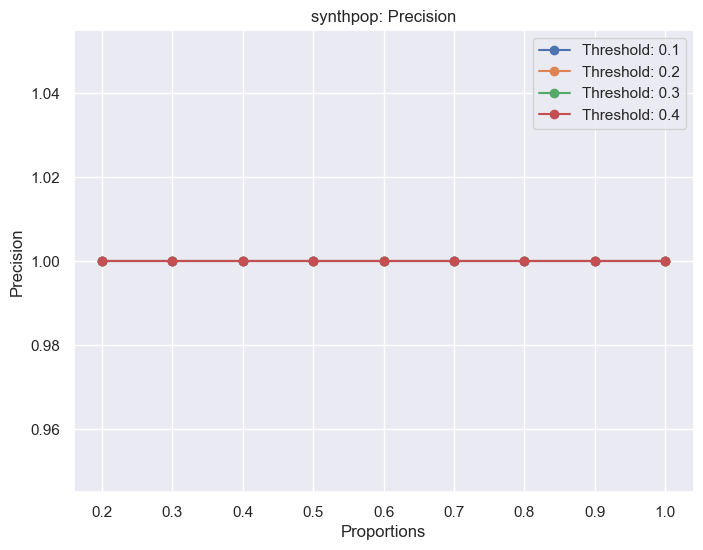

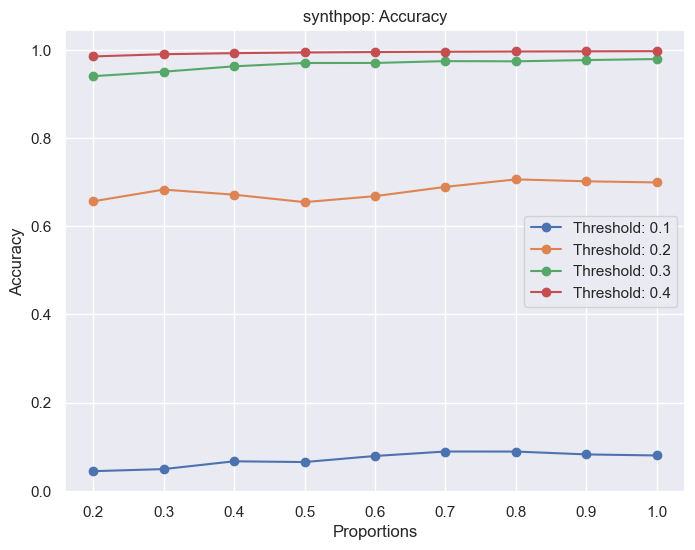

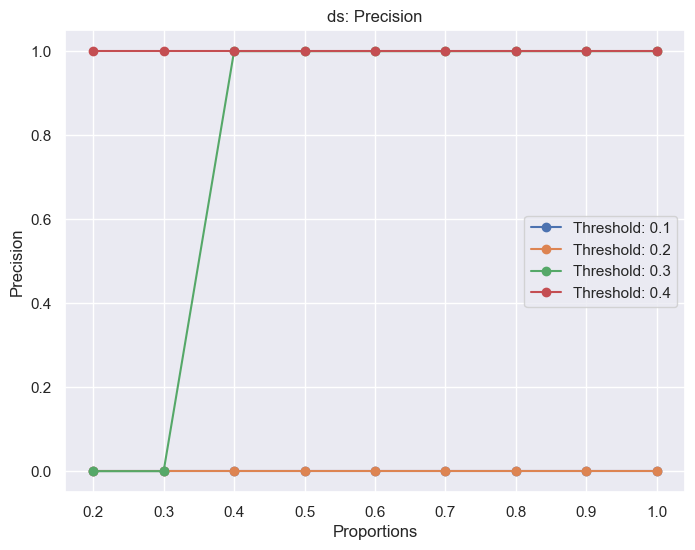

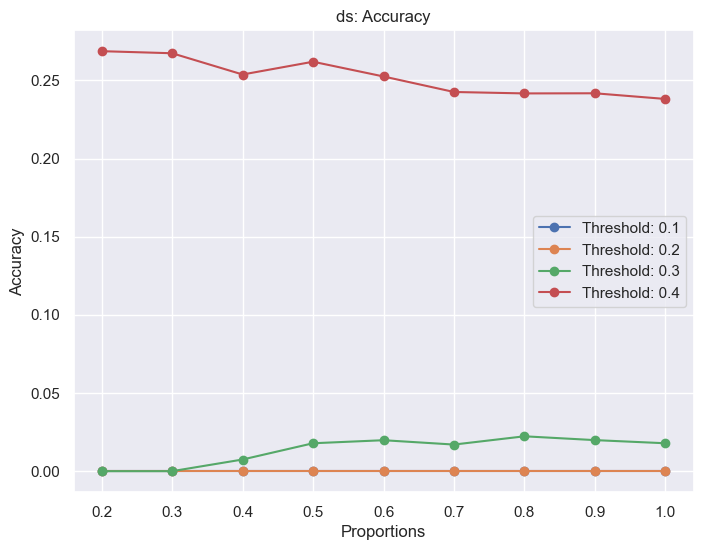

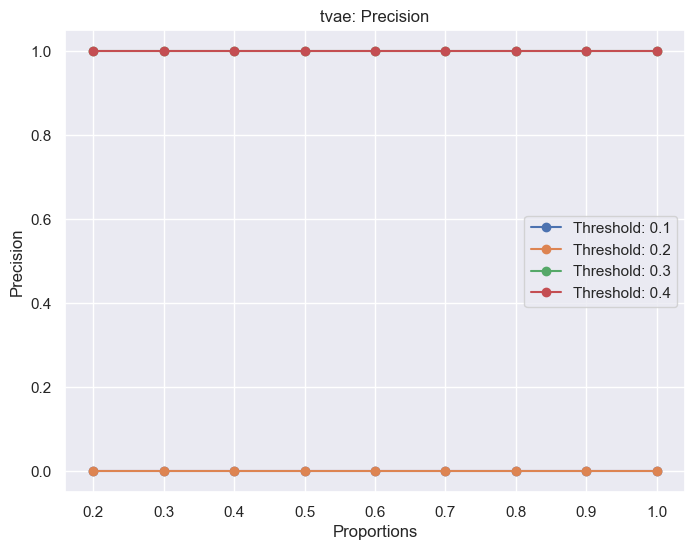

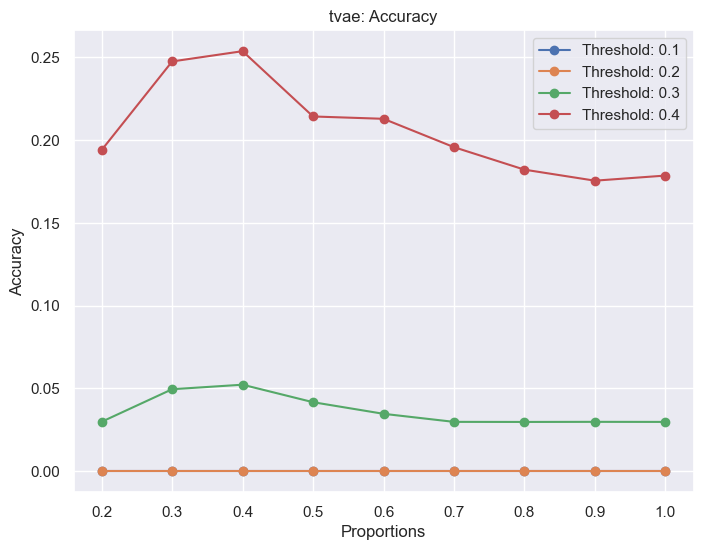

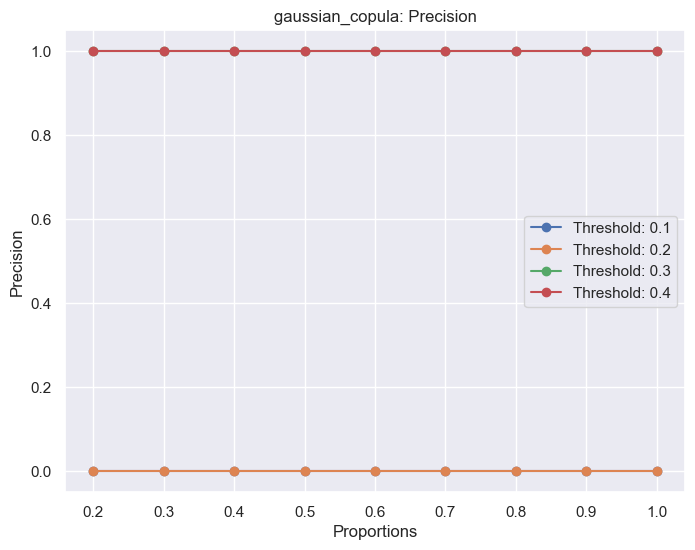

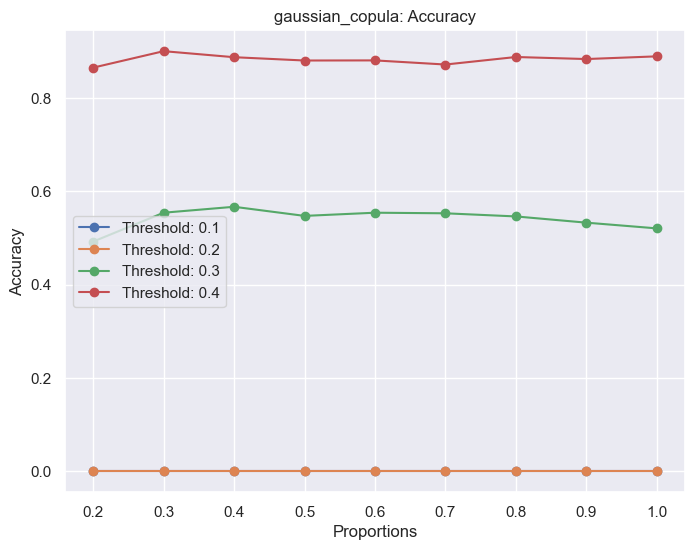

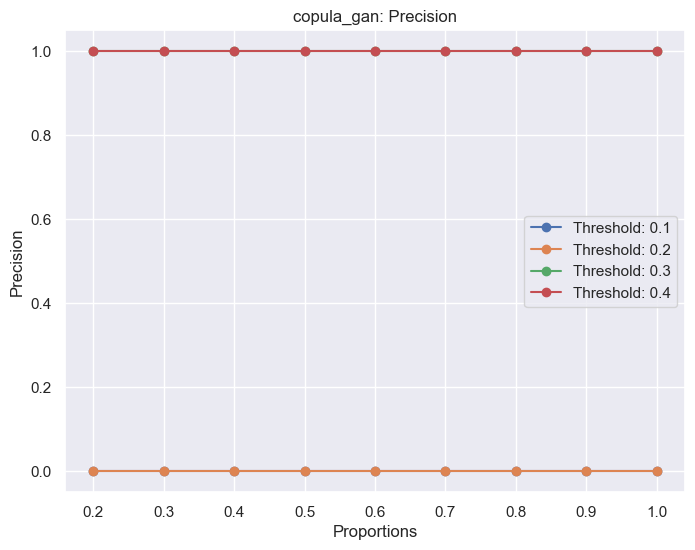

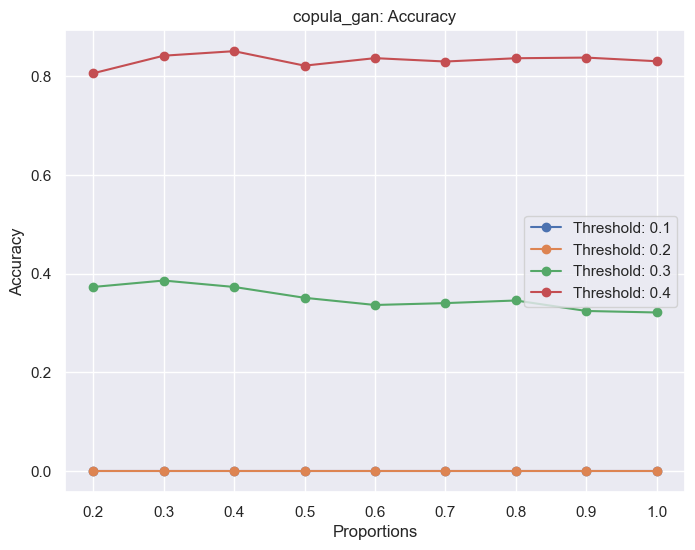

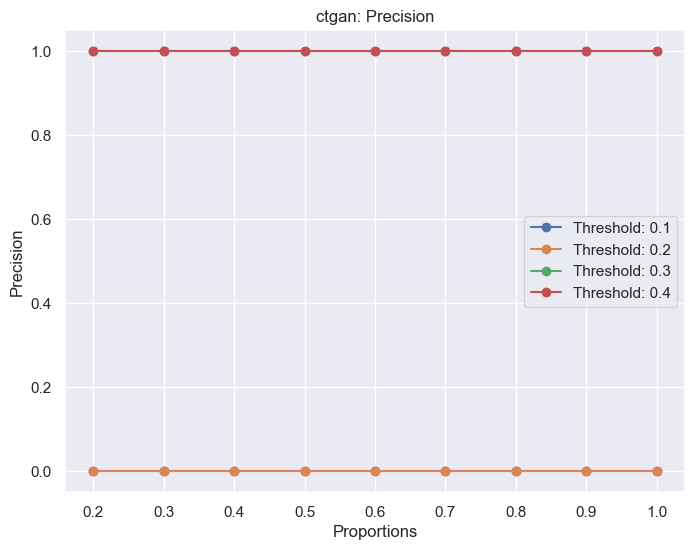

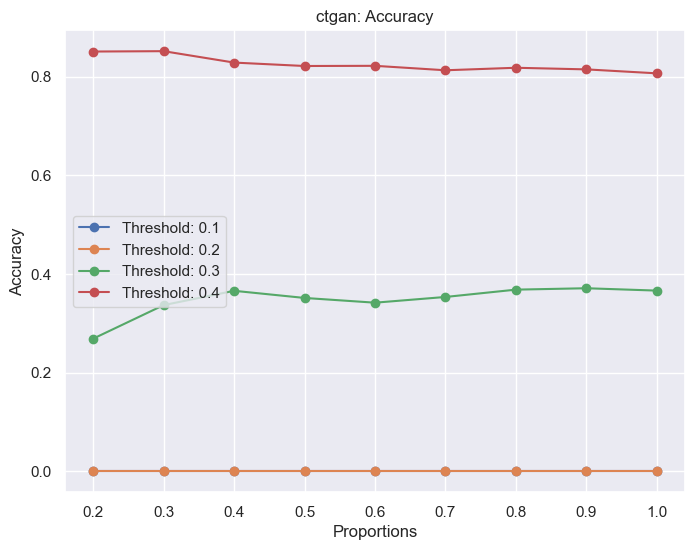

In [60]:
from Data_Evaluation.privacy import mia
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i] + "prec"], mia_results[model_names[i] + "acc"]= mia(train_data, model, model_names[i],save_plts=True)
